## Mini AlexNet Baseline Results

Expects:

- weight.h5 files in ./weights 
- CIFAR10 data in ../data/cifar-10-batches-py/

and while the keras code needs py27, the notebooks can use py3.6 

In [1]:
import sys
import pickle, time
from copy import deepcopy
from shutil import copy
from tqdm import tqdm_notebook as tqdm

import numpy as np
import scipy as sp
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.initializers import Constant
import keras.backend as K

import import_ipynb
import RMT_Util

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

print(sys.version)
print("numpy version {}".format(np.__version__))
print("tensforflow version {}".format(tf.__version__))
print("keras version {}".format(keras.__version__))
print("sklearn version {}".format(sklearn.__version__))

/Users/charlesmartin14/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charlesmartin14/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing notebook from RMT_Util.ipynb
3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.14.2
scipy version 1.0.1
tensforflow version 1.5.0-dev20171116
keras version 2.1.5
sklearn version 0.19.1
powerlaw version 1.4.3
3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.14.2
tensforflow version 1.5.0-dev20171116
keras version 2.1.5
sklearn version 0.19.1


In [2]:
plt.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams.update({'font.size': 16})
plt.tight_layout()

<Figure size 360x360 with 0 Axes>

In [3]:
BASELINE_outfile = 'results/cifar10_alexnet.out'

BASELINE_final_weightfile = 'weights/alexnet.b16.final.h5'
BASELINE_per_epoch_weightfile = "weights/alexnet.b16.e{}.h5"
NUM_BASELINE_EPOCHS = 100

BASELINE_init_weighfile = 'weights/alexnet.b16.e0.h5'

REGULARIZED_final_weightfile = 'weights/alexnet.b16.wd.final.h5'
RANDOMIZED_final_weightfile = 'weights/alexnet.b16.rand100.final.h5'

CIFAR_TEST_BATCH = "./data/cifar-10-batches-py/test_batch"

                                          
BASELINE_ensemble_weightfile = "./weights/alexnet.b16.id{}.final.h5"
NUM_ENSEMBLE_RUNS = 10 

N7, M7 = 4096, 384
N8, M8 = 384, 192

Q7 = float(N7)/float(M7)
Q8 = float(N8)/float(M8)

Q_FC1 = Q7
Q_FC2 = Q8

LAYER_FC1 = 7
LAYER_FC2 = 8

ENTROPY_FILE = "img/mini-alexnet-baseline-entropy-per-epoch.png"
RANK_FILE = "img/mini-alexnet-baseline-rank-per-epoch.png"

ACCURACY_FILE = "img/mini-alexnet-baseline-accuracy-per-epoch.png"

FC1_ESD_PER_EPOCH_FILE = "img/mini-alexnet-fc1-esd-per-epoch.png"
FC2_ESD_PER_EPOCH_FILE = "img/mini-alexnet-fc2-esd-per-epoch.png"

ALPHA = 0.25 # not passing through

XLABEL_FC1 = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}_{FC1}^{T}\mathbf{W}_{FC1}$"
XLABEL_FC2 = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}_{FC2}^{T}\mathbf{W}_{FC2}$"

XLABEL = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}}^{T}\mathbf{W}$"
YLABEL = "Spectral Density"

ESD_FC1_0_EPOCH = "img/mini-alexnet-fc1-esd-epoch-0.png"
ESD_FC2_0_EPOCH = "img/mini-alexnet-fc2-esd-epoch-0.png"
ESD_FC1_FINAL_EPOCH = "img/mini-alexnet-fc1-esd-epoch-final.png"
ESD_FC2_FINAL_EPOCH = "img/mini-alexnet-fc2-esd-epoch-final.png"


ENSEMBLE_ESD_FC1_EPOCH0 = "img/mini-alexnet-fc1-ensemble-esd-epoch0.png"
ENSEMBLE_ESD_FC2_EPOCH0 = "img/mini-alexnet-fc2-ensemble-esd-epoch0.png"

ENSEMBLE_ESD_FC1_FINAL_EPOCH_9SPIKES = "img/mini-alexnet-fc1-ensemble-esd-final-9spikes.png"
ENSEMBLE_ESD_FC1_FINAL_EPOCH_18SPIKES = "img/mini-alexnet-fc1-ensemble-esd-final-18spikes.png"

ENSEMBLE_ESD_FC2_FINAL_EPOCH_9SPIKES = "img/mini-alexnet-fc2-ensemble-esd-final-9spikes.png"
ENSEMBLE_ESD_FC2_FINAL_EPOCH_18SPIKES = "img/mini-alexnet-fc2-ensemble-esd-final-18spikes.png"

ENSEMBLE_ESD_FC1_FINAL_RAND = "img/mini-alexnet-fc1-ensemble-esd-rand-final.png"
ENSEMBLE_ESD_FC2_FINAL_EPOCH = "img/mini-alexnet-fc2-ensemble-esd-rand-final.png"

ENSEMBLE_FC1_3COLOR_ESD = "img/mini-alexnet-fc1-ensemble-3color-ssd.png"

ENSEMBLE_FC1_LOCS =  "img/mini-alexnet-fc1-ensemble-locs.png"
ENSEMBLE_FC1_PARTS =  "img/mini-alexnet-fc1-ensemble-parts.png"
ENSEMBLE_FC1_VENTROPIES =  "img/mini-alexnet-fc1-ensemble-ventropies.png"


In [4]:
!cd weights; ln -s alexnet.b16.final.h5 alexnet.b16.e100.h5
!cd weights; ls -l alexnet.b16.e100.h5

ln: alexnet.b16.e100.h5: File exists
lrwxr-xr-x  1 charlesmartin14  staff  20 Apr 10 23:41 alexnet.b16.e100.h5 -> alexnet.b16.final.h5


## Baseline 

In [5]:
model = RMT_Util.Alexnet_Model()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [6]:
model.load_weights(BASELINE_final_weightfile)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

#### Check baseline shapes

In [7]:
for il, layer in enumerate(model.layers):
    weights = layer.get_weights() 
    if len(weights)>0 :
        W = weights[0]
        print("layer ",il,": ", W.shape)

layer  0 :  (5, 5, 3, 96)
layer  2 :  (96,)
layer  3 :  (5, 5, 96, 256)
layer  5 :  (256,)
layer  7 :  (4096, 384)
layer  8 :  (384, 192)
layer  9 :  (192, 10)


###  Baseline Ensemble Fits
### <font color='red'>IDs 1 and 2 were corrupted<font>

### FC1

In [8]:
eigenvalues, _ = RMT_Util.keras_ensemble_spectrum(model, 
                        BASELINE_ensemble_weightfile, LAYER_FC1,num_runs=NUM_ENSEMBLE_RUNS)

In [9]:
assert(len(eigenvalues)==NUM_ENSEMBLE_RUNS)


In [10]:
# all_evals=np.concatenate(eigenvalues)
all_evals = []
for i in tqdm(range(len(eigenvalues))):
    all_evals.extend(eigenvalues[i-1])

### First get Baseline Shuffled sigma to select best $\lambda_{max}$

get_shuffled_eigenvalues



RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 0.00
% sigma 1.2456
1.2456492738440388
saved figure img/mini-alexnet-fc1-ensemble-esd-rand-final.png


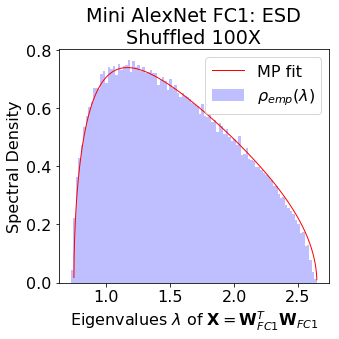

In [11]:
W = model.layers[LAYER_FC1].get_weights()[0]
shuffled_evals = RMT_Util.get_shuffled_eigenvalues(W, layer=LAYER_FC1, num=100)
sigma = RMT_Util.plot_ESD_and_fit(eigenvalues=shuffled_evals, Q=Q_FC1, 
                                  layer=LAYER_FC1, num_spikes=0)
print(sigma)
plt.title("Mini AlexNet FC1: ESD\nShuffled 100X")
plt.xlabel(XLABEL_FC1)
plt.ylabel(YLABEL)
plt.legend()
plt.tight_layout()

filename=ENSEMBLE_ESD_FC1_FINAL_RAND
plt.savefig(filename)
print("saved figure {}".format(filename))

### Now select # spikes

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 2.40
% sigma 1.2714
1.2713706557882887
saved figure img/mini-alexnet-fc1-ensemble-esd-final-9spikes.png


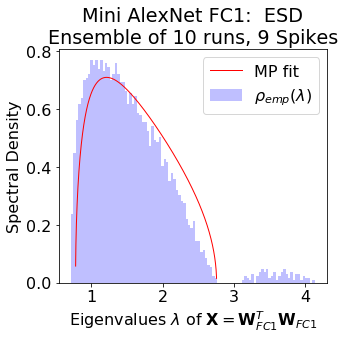

In [12]:
sigma = RMT_Util.plot_ESD_and_fit(eigenvalues=all_evals, Q=Q_FC1,  
                                  layer=LAYER_FC1, num_spikes=NUM_ENSEMBLE_RUNS*9)
print(sigma)

plt.title("Mini AlexNet FC1:  ESD\nEnsemble of 10 runs, 9 Spikes")
plt.xlabel(XLABEL_FC1)
plt.ylabel(YLABEL)
plt.legend()
plt.tight_layout()

filename=ENSEMBLE_ESD_FC1_FINAL_EPOCH_9SPIKES
plt.savefig(filename)
print("saved figure {}".format(filename))

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 4.92
% sigma 1.2039
1.2039065911893958
saved figure img/mini-alexnet-fc1-ensemble-esd-final-18spikes.png


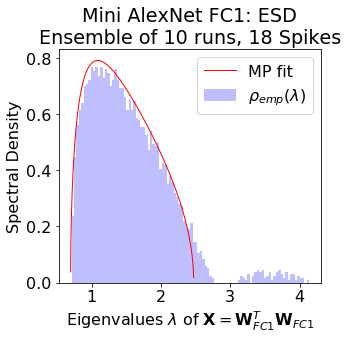

In [13]:
num_spikes = NUM_ENSEMBLE_RUNS*18
sigma = RMT_Util.plot_ESD_and_fit(eigenvalues=all_evals, 
                                  Q=Q_FC1, layer=LAYER_FC1, num_spikes=num_spikes)
print(sigma)

plt.title("Mini AlexNet FC1: ESD\nEnsemble of 10 runs, 18 Spikes")
plt.xlabel(XLABEL_FC1)
plt.ylabel(YLABEL)
plt.legend()
plt.tight_layout()

filename=ENSEMBLE_ESD_FC1_FINAL_EPOCH_18SPIKES
plt.savefig(filename)
print("saved figure {}".format(filename))

## Repear for FC2

In [14]:
eigenvalues, eigenvectors = RMT_Util.keras_ensemble_spectrum(model, 
                        BASELINE_ensemble_weightfile, LAYER_FC2,num_runs=NUM_ENSEMBLE_RUNS)
all_evals = np.concatenate(eigenvalues)

% spikes outside bulk 4.92
% sigma 1.0109
1.0109147957317495


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc2-ensemble-esd-final-9spikes.png


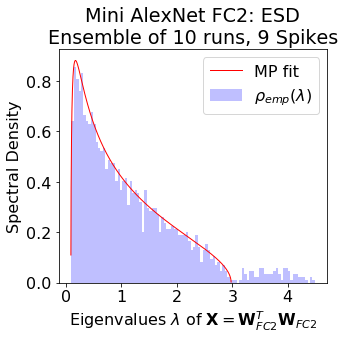

In [15]:
all_evals = np.array(eigenvalues).flatten()
num_spikes = NUM_ENSEMBLE_RUNS*9
sigma = RMT_Util.plot_ESD_and_fit(eigenvalues=all_evals, Q=Q_FC2, 
                                  layer=LAYER_FC2, num_spikes=num_spikes)
print(sigma)
plt.title("Mini AlexNet FC2: ESD\nEnsemble of 10 runs, 9 Spikes")
plt.xlabel(XLABEL_FC2)
plt.ylabel(YLABEL)
plt.legend()
plt.tight_layout()

filename=ENSEMBLE_ESD_FC2_FINAL_EPOCH_9SPIKES
plt.savefig(filename)
print("saved figure {}".format(filename))

### Localization

In [16]:
svals, svecs = RMT_Util.keras_singular_spectrum(model, 
                        BASELINE_ensemble_weightfile, LAYER_FC1,num_runs=NUM_ENSEMBLE_RUNS)

In [17]:
num_spikes = 9
num_bleeding_out = 9
bulk_svals, bleeding_svals, spiked_svals = [], [], []
bulk_svecs, bleeding_svecs, spiked_svecs = [], [], []

for i in range(len(eigenvalues)):
    spiked_svals.extend(svals[i][0:num_spikes])
    bleeding_svals.extend(svals[i][num_spikes:num_spikes+num_bleeding_out])
    bulk_svals.extend(svals[i][num_spikes+num_bleeding_out:])
    
    spiked_svecs.extend(svecs[i][0:num_spikes])
    bleeding_svecs.extend(svecs[i][num_spikes:num_spikes+num_bleeding_out])
    bulk_svecs.extend(svecs[i][num_spikes+num_bleeding_out:])
    


No handles with labels found to put in legend.


saved figure img/mini-alexnet-fc1-ensemble-3color-ssd.png


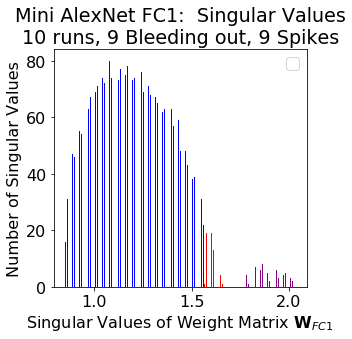

In [18]:
x = [bulk_svals,bleeding_svals,spiked_svals]
plt.hist(x, bins=100, color=['blue', 'red', 'purple']);
plt.title("Mini AlexNet FC1:  Singular Values\n10 runs, 9 Bleeding out, 9 Spikes")
plt.ylabel("Number of Singular Values")
plt.xlabel(r"Singular Values of Weight Matrix $\mathbf{W}_{FC1}$")
plt.legend()
plt.tight_layout()

filename=ENSEMBLE_FC1_3COLOR_ESD
plt.savefig(filename)
print("saved figure {}".format(filename))

In [19]:
bulk_loc = [RMT_Util.localization_ratio(v) for v in bulk_svecs]
bleeding_loc = [RMT_Util.localization_ratio(v) for v in bleeding_svecs]
spike_loc = [RMT_Util.localization_ratio(v) for v in spiked_svecs]

97.7284 82.91064
saved figure img/mini-alexnet-fc1-ensemble-locs.png


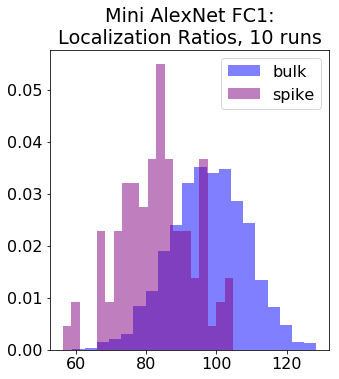

In [40]:
plt.hist(bulk_loc, bins=20, density=True, alpha =0.50, color='blue', label='bulk');
#plt.hist(bleeding_loc, bins=100, density=True, alpha = 0.50, color='red');
plt.hist(spike_loc, bins=20, density=True, alpha = 0.50, color='purple', label='spike');
plt.legend()
plt.tight_layout()
print(np.mean(bulk_loc), np.mean(spike_loc))

plt.title("Mini AlexNet FC1:\nLocalization Ratios, 10 runs")
filename=ENSEMBLE_FC1_LOCS
plt.savefig(filename)
print("saved figure {}".format(filename))

In [21]:
bulk_part = [RMT_Util.participation_ratio(v) for v in bulk_svecs]
bleeding_part = [RMT_Util.participation_ratio(v) for v in bleeding_svecs]
spike_part = [RMT_Util.participation_ratio(v) for v in spiked_svecs]

3.370514254754385 3.209000675657671
saved figure img/mini-alexnet-fc1-ensemble-parts.png


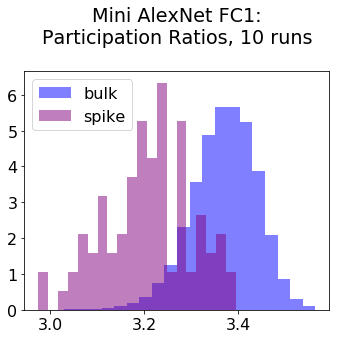

In [37]:
plt.hist(bulk_part, bins=20, density=True, alpha =0.50, color='blue', label='bulk');
#plt.hist(bleeding_loc, bins=100, density=True, alpha = 0.50, color='red');
plt.hist(spike_part, bins=20, density=True, alpha = 0.50, color='purple', label='spike');
plt.title("Mini AlexNet FC1:\nParticipation Ratios, 10 runs\n")
plt.legend()
plt.tight_layout()
print(np.mean(bulk_part), np.mean(spike_part))

filename=ENSEMBLE_FC1_PARTS
plt.savefig(filename)
print("saved figure {}".format(filename))

### Entropy: need good histogram estimator

https://stackoverflow.com/questions/39626432/how-to-calculate-entropy-from-np-histogram?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

https://github.com/rmcgibbo/information

https://github.com/rmcgibbo/information


In [23]:

def discrete_entropy(vec, num_bins=100):
    vec = vec - np.mean(vec)
    h = np.histogram(vec, density=True, bins=num_bins)[0];
    p = np.array(h)+0.0000000001
    
    p = p / np.sqrt(2*np.pi)
    p = p / np.sum(p)

    #p = p/(2*np.pi)
    entropy = -np.sum(p*np.log(p))
    entropy = entropy#/(2*np.pi)#/float(num_bins)
    return entropy

### compute maximum possible entropy for this vector length and bin sizes

In [24]:

def max_discrete_entropy(len_vec,num_bins=100, sample_size = 100000):
    """compute maximum possible entropy for this vector length and bin sizes"""
    entropies = []
    for i in tqdm(range(sample_size)):
        test_vec = np.random.normal(0,1,len_vec)
        s = discrete_entropy(test_vec, num_bins=num_bins)
        entropies.append(s)

    return np.max(entropies)

In [25]:
max_discrete_entropy(len(bulk_svecs[0]))

4.365803034769936

In [26]:
bulk_entropy = [discrete_entropy(v) for v in tqdm(bulk_svecs)]
#bleeding_entropy = [discrete_entropy(v) for v in bleeding_svecs]
spike_entropy  = [discrete_entropy(v) for v in tqdm(spiked_svecs)]

In [27]:
np.mean(bulk_entropy), np.mean(spike_entropy), np.mean(bulk_entropy)- np.mean(spike_entropy)

(4.1085782855251844, 3.9915675648641415, 0.1170107206610429)

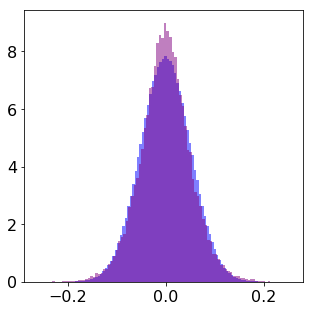

In [28]:
plt.hist(np.concatenate(bulk_svecs), bins=100, alpha=0.5, color='blue', density=True);
#plt.hist(np.concatenate(bleeding_svecs), bins=100, alpha=0.5, color='red', density=True);
plt.hist(np.concatenate(spiked_svecs), bins=100, alpha=0.5, color='purple', density=True);

0.9432414711688868 0.9163783188498249
saved figure img/mini-alexnet-fc1-ensemble-ventropies.png


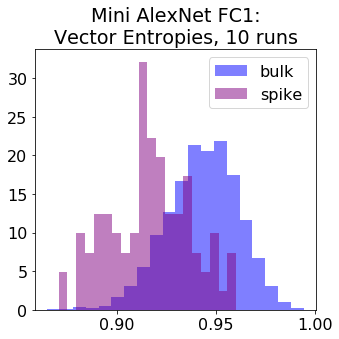

In [41]:
plt.hist(np.array(bulk_entropy), bins=20, density=True, alpha =0.50, color='blue', label='bulk');
#plt.hist(bleeding_entropy, bins=100, density=True, alpha = 0.50, color='red');
plt.hist(np.array(spike_entropy), bins=20, density=True, alpha = 0.50, color='purple', label='spike');
plt.title("Mini AlexNet FC1:\nVector Entropies, 10 runs")
plt.legend();

print(np.mean(bulk_entropy), np.mean(spike_entropy))
filename=ENSEMBLE_FC1_VENTROPIES
plt.savefig(filename)
plt.legend()
plt.tight_layout()
print("saved figure {}".format(filename))

In [30]:
max_entropy = max_discrete_entropy(len(bulk_svecs[0]))
bulk_entropy = bulk_entropy/max_entropy
spike_entropy = spike_entropy/max_entropy

0.9432414711688868 0.9163783188498249
saved figure img/mini-alexnet-fc1-ensemble-ventropies.png


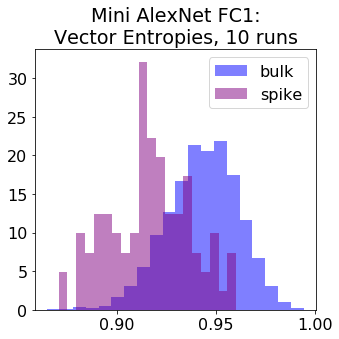

In [42]:
plt.hist(np.array(bulk_entropy), bins=20, density=True, alpha =0.50, color='blue', label='bulk');
#plt.hist(bleeding_entropy, bins=100, density=True, alpha = 0.50, color='red');
plt.hist(np.array(spike_entropy), bins=20, density=True, alpha = 0.50, color='purple', label='spike');
plt.title("Mini AlexNet FC1:\nVector Entropies, 10 runs")
plt.legend()
plt.tight_layout()

print(np.mean(bulk_entropy), np.mean(spike_entropy))
filename=ENSEMBLE_FC1_VENTROPIES
plt.savefig(filename)
print("saved figure {}".format(filename))